In [80]:
import numpy as np
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn import linear_model
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn import datasets
from sklearn.datasets import make_moons
from sklearn import metrics
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from scipy.special import binom
%matplotlib inline

## 1. Overview & Background

**Machine Learning**: Developing Algorithms and models that improve their performance at a task by processing data.

**Data**: Sets of features, $x_i$ and (optionally) labels $y_i$. A *label* is the ideal answer we'd like our ML model to give when inputed the features $x$.

In **Supervised Learning**, our model expects to train on both features and labels. The task is to construct an model which is able to predict the label of an object given the set of features.

Supervised learning is further broken down into two categories, **classification** and **regression**.
In *classification* problems, the labels are discrete, and dont come from a metric space. An example of classification is to determine if a person has the flu based on their vital signs.
In *regression* problems, the labels are continous and from a metric space. An example of regression is to determine a person's body temperature, given their vital signs.

![alt text](Errata/MLSchematic.jpg)

### Supervised Learning

An (approximate and generic) outline of the development of a supervised learning model is given below. The basis is an "unknown" physics based phenomenon. We have some data to represent this phenomenon. It could be from real life experiments, from simplified simulations, etc. This data consists of features that describe the system settings and targets that describe the ideal/real-life system output. The catch is how to go from this dataset to a ML model...and how to go about this in the best manner possible?

![alt text](Errata/MachineLearningFlowchart.jpg)

We can decompose this exercise into discrete steps:
1) Selecting an appropriate error metric,

2) Selecting a Hypothesis set,

3) Selecting an optimization approach,

4) Regularization to control this optimization,

5) Data splits and data preprocessing,

6) Estimation of generalization error.

#### Error Metrics: Central Underlying Principles

Before we start training our models via numerical optimization, we need to determine an objective to be optimized. Here, we will go over common error metrics (also known as Cost functions or Loss functions) for regression and classification.

What we will see, is that there is an underlying central concept and (most) error measures are derived based on this concept. 

To follow along, I'm hoping that you're comfortable with 3 probability distributions:

a) **Bernoulli**, if $X\sim Bernoulli(f)$ then $P(X=1)=f$. eg, a singleton toss of a biased/unbiased coin;

b) **Binomial**, if $X \sim Binomial(f,N)$ then $P(X=k)=\binom{N}{k} f^k (1-f)^{N-k}$. eg, how many heads will I get in 10 tosses of this biased coin?

c) **Gaussian/Normal**, if $X \sim \mathcal{N}(\mu, \sigma)$, then $f_X(x)=\frac{1}{\sigma\sqrt{2\pi}}\exp\left(-\frac{1}{2}\left(\frac{x-\mu}{\sigma}\right)^{2}\right)$.


**Exercise 1**:

You have been given a fair, 6-sided die, with five ivory faces and the sixth painted red. If you roll this die 10 times, what is the probability of the number of times you will end up with the red face?

Create a final plot, with the x axis showing the number of times you see the red face and the y axis reporting the probability of the event.

In [12]:
#Hint: for the binomial coefficient, you can use the scipy.special.binom() function
# so to calculate 4 choose 2
binom(4,2)

6.0

**Exercise**:

Your "best friend" has a similar die with ivory and red faces, but she doesnt know the number of red faces. She tells you that on rolling the die 10 times, she observed only 2 red faces.

_SUPER IMPORTANT DEFINTION_:

The likelihood of a parameter, $\theta$, is the probability of observing an event conditioned on the value of the parameter, $P(event| \theta)$.

$L(\theta=k) = P(event| \theta=k)$

a) Conditioning the probability of the event (ie, seeing 2 red faces in 10 rolls) on the number of red faces on her die, report the likelihoods for having 1-red face, 2-red faces....,6 red-faces. Calculate and plot the values.

b) What is your guess for the number of red faces on her die? _Why?_

This approach to estimating a parameter's values is referred to as the Maximum Likelihood Estimation (MLE). The value of the paramater estimated using this is referred to as the Maximum Likelihood Estimator, $\hat{\theta}_{MLE}$.

In supervised learning, you select the form of the ML model by selecting your hypothesis (eg, linear regression, Neural networks, etc). To determine the coefficients/weights/parameters of your model, you simply maximize the likelihood or the probability of observing the data conditioned on the parameter values.

**Binary Classification**

Let's apply this Maximum Likelihood Estimation approach for a general binary classification problem. So, I have a set of data points $\{(x_i,y_i)\}$, where $y_i \in \{0,1\}$.

We assume the target y to be sampled from a Bernoulli distribution. I can express this as a quasi-coin toss, where

$P(y_i=1)=\theta(x_i), ~ ~ P(y_i=1)=1-\theta(x_i).$ Thus, the probability of observing y=1 is given by $\theta$ modeled as a function of the features, x.

$L=P(Data|\theta)$

Assuming that the data is independent and identically distributed (iid),

$L= \prod_{i\in S_1} \theta_i ~ \prod_{i\in S_0} (1-\theta_i)$

Taking a logarithm, we get the log likelihood (as the log is monotonic, we dont change the location of the optimum):

$l=\sum_{i\in S_1} ln(\theta_i) ~ \sum_{i\in S_0} ln(1-\theta_i)$

$l=\sum_{i}[ y_i ln(\theta_i) ~+ (1-y_i) ln(1-\theta_i)]$

To maximize the likelihood is equivalent to minimizing the negative of the likelihood, giving us the Negative Log Likelihood:
$NLL=-\sum_{i}[ y_i ln(\theta_i) ~+ (1-y_i) ln(1-\theta_i)]$

This is often referred to as the Binary Cross Entropy loss.

**Exercise**

I have a binary classification problem with a evenly sampled dataset. I randomly guess the classes for each data point. What should be the value of my Binary Cross Entropy loss from this naive prediction?

**Regression**

For a regression problem, we assume our target y to be sampled from a Normal/Gaussian distribution.
$f_Y(y)=\frac{1}{\sigma\sqrt{2\pi}}\exp\left(-\frac{1}{2}\left(\frac{y-\mu}{\sigma}\right)^{2}\right)$.

We model the unknown parameter of this distribution $\mu$ as a function of the features,
$\mu=\mu(x)$. The standard deviation is assumed to be a constant.

Thus, the Likelihood is given by

$L=\prod_{i} \frac{1}{\sigma\sqrt{2\pi}} ~~ \exp\left(-\frac{1}{2}\sum_{i}\left(\frac{y_i-\mu(x_i)}{\sigma}\right)^{2}\right)$

The log likelihood is given by:

$l= -C-\frac{1}{2 \sigma^2}\sum_{i}(y_i-\mu(x_i))^2$

And, the Negative Log Likelihood (to be minimized) is

$NLL=C+\frac{1}{2 \sigma^2}\sum_{i}(y_i-\mu(x_i))^2$

This is often referred to as the mean squared error.

### Optimization: Steepest Gradient Methods

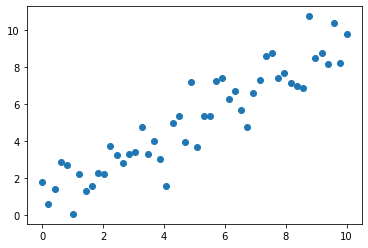

In [27]:
np.random.seed(0)
X = np.linspace(0,10,50)
y = 1.0*X +np.random.normal(size=50)

plt.scatter(X,y)

In [28]:
def mymse(y,yhat):
    return 0.5*np.dot(y-yhat, y-yhat)/y.shape[0]

I'm going to try to fit a line through this dataset,
$y=m x$. (only slope, No intercept)

I would evaluate the quality of the fit with the mean squared error, and ideally I would want the final value of the slope to correspond to the lowest mean squared error possible.

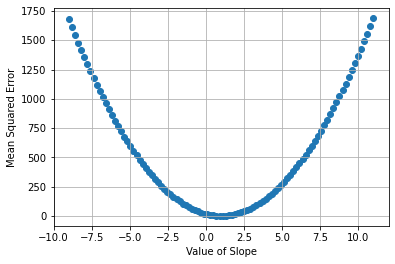

In [31]:
slopes=np.linspace(-9,11,100)
losses=[mymse(y,slope*X) for slope in slopes]

plt.scatter(slopes, losses)
plt.xlabel("Value of Slope")
plt.ylabel("Mean Squared Error")
plt.grid()

$\frac{\nabla f(x)}{|\nabla f(x)|}$ represents the unit vector along the direction of maximum increase for the function $f(x)$, locally. Thus, 

changing $x$ (by a small amount) along this direction will lead to the highest increase in the value of $f(x)$. This is gradient ascent, useful for maximization.

changing $x$ (by a small amount) opposite to this direction will lead to the higest decrease in the value of $f(x)$. This is gradient descent, useful for maximization.

Gradient Descent:

1) Start with a guessed initial value of your model parameters, $\beta_0$

2) Calculate the error at this value of the parameters, $E(\beta_0)$

3) While some condition is not met (ie, number of iterations or minimum error threshold), for iteration n

---Calculate the gradient of the Error, $\frac{\partial E(\beta_n)}{\partial \beta_n}$

---Correct the value of the parameters, $\beta_{n+1}= \beta_n - \alpha \times \frac{\partial E(\beta_n)}{\partial \beta_n} $

---Calculate the error at this value of the parameters, $E(\beta_{n+1})$

4) These are your optimal values of the model parameters, $\beta_{m}$  conditioned upon the training data.

**Introduction to Simple Linear Regression & Gradient Descent**

**Exercise**: 

Write a class for a regressor, based on the outline given below.

Then instantiate a member of this class, train it on the dataset in the cell that follows and report your error.

In [76]:
class mylinearregression():
    def __init__(self):
        self.beta=...
        
    def predict(self, X):
        #np.dot(X,self.beta)
        
    def error(self, X, Y):
        #(np.dot((Ytrue-Ypredicted).T,(Yrue-Ypredicted))/n).item()
        
    def gradients(self, X, Y):
        #(np.dot(self.beta.T, np.dot(X.T,X))-np.dot(Y.T,X)).T
        
    
    def fit(self, X, Y, num_epochs=50, lr=0.001):


In [91]:
np.random.seed(0)
x = np.linspace(0,10,50)
y = 2.0*x+ 0.5 +np.random.normal(size=50)

Y=y[:,np.newaxis]
temp=np.ones_like(x)
X=np.stack([temp,x]).T

![alt text](Errata/ErrorSurfacesFigure.jpg)

### Break

For the exercises hereon, we shall be using the [scikit-learn](http://scikit-learn.org) library.

Most machine learning algorithms implemented in scikit-learn expect data to be stored in a
**two-dimensional array or matrix**.  The arrays can be
either ``numpy`` arrays, or ``scipy.sparse`` matrices.
The size of the array is expected to be `[n_samples, n_features]`

- **n_samples:**   The number of samples: each sample is an item to process (e.g. classify).
  A sample can be a document, a picture, a sound, a video, a row in database or CSV file,
  or whatever you can describe with a fixed set of quantitative traits.
- **n_features:**  The number of features or distinct traits that can be used to describe each
  item in a quantitative manner.  Features are generally real-valued, but may be boolean or
  discrete-valued in some cases.

The number of features must be fixed in advance. However it can be very high dimensional
(e.g. millions of features). For Supervised learning problems, data in scikit-learn is represented as a **feature matrix** and a **label vector**

$$
{\rm feature~matrix:~~~} {\bf X}~=~\left[
\begin{matrix}
x_{11} & x_{12} & \cdots & x_{1D}\\
x_{21} & x_{22} & \cdots & x_{2D}\\
x_{31} & x_{32} & \cdots & x_{3D}\\
\vdots & \vdots & \ddots & \vdots\\
\vdots & \vdots & \ddots & \vdots\\
x_{N1} & x_{N2} & \cdots & x_{ND}\\
\end{matrix}
\right]
$$

$$
{\rm label~vector:~~~} {\bf y}~=~ [y_1, y_2, y_3, \cdots y_N]
$$

Here there are $N$ samples and $D$ features.

## 2. Supervised Learning: Regression

**Exercise 5** 

a) Please use numpy to create a data set with 50 points corresponding to a line with slope 2 and intercept 5, with standard normal noise at each point. Please arrange this data with all the x-values as a feature matrix, and the y values as the label vector. ($y_i=2 \times x_i + 5 + \epsilon_i$)

b) Create a scatter plot of these using matplotlib.

(I've started the exercise code for you. The solutions are at the bottom of this notebook)

#### 2.1 Data Structuring

In [92]:
np.random.seed(0)
#X = 

##### 2.2 Normalize Data


![alt text](Errata/Normalization.jpg)



For gradient descent type applications, we'd like all features to have similar means, variances and ranges; so that the error surface is properly shaped. Else, we can get into wild oscillations during optimization iterations and even a loss of convergence.

The MinMaxScaler() is one of the data scaling and normalization functions available. 
It takes a **2D** matrix as input to be scaled and (optionally) the range to be scaled to.

It applies a 2 step transform:

Step 1: X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))

Step 2: X_scaled = X_std * (max_of_range - min_of_range) + min_of_range

To use this scaler, 

a) Instantiate the scaler with the range that you'd like to scale to,

b) fit the scaler on your data,

c) Use this fitted scaler to transform your data.

In [5]:
scalerX=MinMaxScaler(feature_range=(-1,1)) #instantiate with the range
scalerX.fit(X)                             #Fit on data
Xnorm=scalerX.transform(X)                 #Transform data

In [6]:
scalerY=MinMaxScaler(feature_range=(-1,1))
scalerY.fit(y[:,np.newaxis]) 
ynorm=scalerY.transform(y[:,np.newaxis])

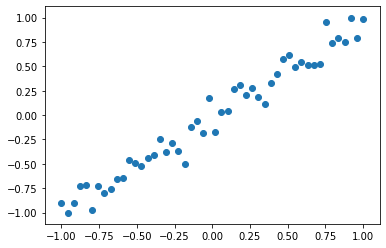

In [7]:
plt.scatter(Xnorm,ynorm)

**Important**
When you're making your final plots, you may want the answers to be unscaled.
In that case, use the inverse_transform() method of the trained scaler.

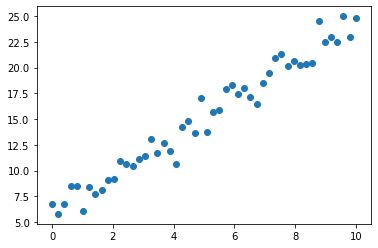

In [8]:
Xunscaled=scalerX.inverse_transform(Xnorm)
yunscaled=scalerY.inverse_transform(ynorm)
plt.scatter(Xunscaled,yunscaled)

#### 2.3 Regression Model

A basic scikit-learn supervised learning model, there are 3 steps:

a) Instantiate: Declare an instance of a specific model,

b) Train: Fit (or train) this model instance on data,

c) Analyze: Use this trained model to make predictions for new data, analyze model coefficients.

Let's see these steps in action, using a linear regression model on our data.

In [9]:
# Step 1: Declare an instance of a linear regressor
model = LinearRegression(normalize=True)

In [10]:
# Step 2: Fit the model on data
model.fit(X, y) 

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

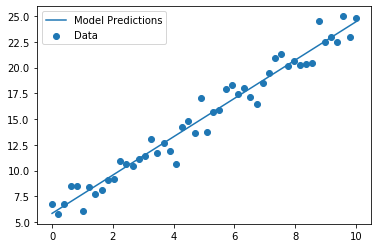

In [11]:
# Step 3: Make predictions
y_pred=model.predict(X)

plt.figure()
plt.scatter(X,y,label="Data")
plt.plot(X,y_pred,label="Model Predictions")
plt.legend()

In [12]:
# Evaluate Coefficients of Trained Model:
print("Slope: ",model.coef_)
print("Intercept: ",model.intercept_)

Slope:  [1.85883775]
Intercept:  5.846370518808186


In [13]:
# Evaluate Error of trained Model:
print ("mean squared error:", metrics.mean_squared_error(model.predict(X), y))

mean squared error: 1.0939675229281411


### Difference between Curve-fitting and Machine Learning

**Generalizability**: How well does my trained model perform on data that it has never seen? 
Exam questions analogy.

**Dividing Learning Data set into train-test sets**

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

**Exercise 6** 

a) Use this split dataset to train and evaluate a (new) Linear Regression model. Use the train dataset (X_train, y_train) to train the model. Use the test dataset to evaluate the performance. 

b) Plot the model predictions on the test dataset versus the test data.

### Linear regression: Using higher order fits

In [93]:
def complex_regression_data(x, err=0.5):
    y = 10 - 1. / (x + 0.1)
    if err > 0:
        y = np.random.normal(y, err)
    return y

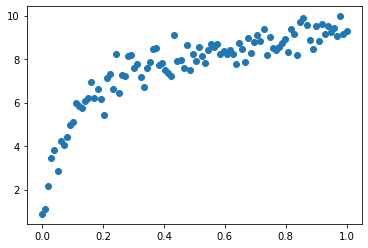

In [94]:
X = np.linspace(0,1,100)[:,np.newaxis]
y=complex_regression_data(X)

plt.scatter(X,y)

mean squared error: 1.0407097692686187


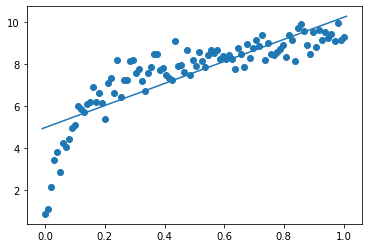

In [95]:
model = LinearRegression()
model.fit(X, y)
X_test = np.linspace(-0.01, 1.01, 500)[:, None]
y_test = model.predict(X_test)

plt.scatter(X.ravel(), y)
plt.plot(X_test.ravel(), y_test)
print ("mean squared error:", metrics.mean_squared_error(model.predict(X), y))

In [96]:
class PolynomialRegression(LinearRegression):
    def __init__(self, degree=1, **kwargs):
        self.degree = degree
        LinearRegression.__init__(self, **kwargs)
        
    def fit(self, X, y):
        if X.shape[1] != 1:
            raise ValueError("Only 1D data, Please!")
        Xp = X ** (1 + np.arange(self.degree))
        return LinearRegression.fit(self, Xp, y)
        
    def predict(self, X):
        Xp = X ** (1 + np.arange(self.degree))
        return LinearRegression.predict(self, Xp)
    
    def err(self,X,y):
        Xp = X ** (1 + np.arange(self.degree))
        yp=LinearRegression.predict(self, Xp)
        return np.mean((y-yp)*(y-yp))

mean squared error: 0.5539669019253836


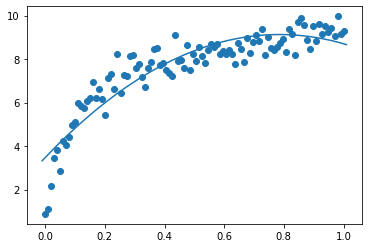

In [97]:
model = PolynomialRegression(degree=2)
model.fit(X, y)
y_test = model.predict(X_test)

plt.scatter(X.ravel(), y)
plt.plot(X_test.ravel(), y_test)
print ("mean squared error:", metrics.mean_squared_error(model.predict(X), y))

### Hyperparameters & Validation Data

*Parameters*: Variables describing the model that are tuned using the training data, for instance, the slope and the intercept, the weights & biases of a neural network.

*Hyperparameters*: Variables describing the model that are not tuned using the training data, for instance, the degree of the model expression, the architecture of the neural network.

Hyperparameters are traditionally set using validation or cross validation. In good old fashioned validation, you divide your original dataset into **3** parts: Training, validation (or "holdout") and testing.

The training data is used to *tune* model parameters, 

the validation data is used to *select* model hyperparameters,

the testing data is used to *report* an estimate for generalization error.

In [99]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, train_size=0.6)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, train_size=0.5)

X_train.shape,X_val.shape,X_test.shape

((60, 1), (20, 1), (20, 1))

**Exercise 7** 

Use this split dataset to train and evaluate a (new) Regression model. Select the best degree of the model by using the error on the validation dataset.
The splits have been made for you.

Create a loop over the degrees.

For each iteration of the loop, instantiate a PolynomialRegression model with the correct degree.

Train this instance on the training data.

Evaluate the trained model on the validation dataset.

Plot the validation error versus the degree of the PolynomialRegression after the loop.

Note: Let's only have degrees from 1 to 8.

### Overfitting & Regularization

*Regularization*: Adding external information to a machine learning model to make it "well-posed".

Traditionally, we express a preference towards simpler, smoother models by adding a penalty.

Model Error: $\sum (y_i-\hat{y_i})^2 + \lambda \sum ||W_j||^2$

L2 Regularization, aka, Ridge Regression.

$\lambda$, is the regularization parameter and is a hyperparameter.

The **Diabetes Dataset**: 442 measurements from diabetes patients on features like age, sex, BMI, Blood Pressure, Serum measurements. The target is quantitative measurement of the progress of diabetes one year after these measurements were taken. 

A **good** ML model would be useful not just to predict the future incidence for new patients, but also evaluate the importance of different features on the progress of the disease.

Cite[Efron, Hastie, etc "LARS"]

In [32]:
dataset=datasets.load_diabetes()

In [33]:
X=dataset.data
y=dataset.target

In [34]:
print(dataset.feature_names)

['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']


Text(0, 0.5, 'Response')

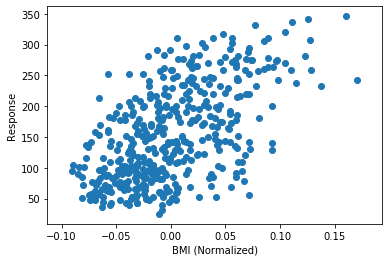

In [35]:
plt.scatter(X[:,2],y)
plt.xlabel("BMI (Normalized)")
plt.ylabel("Response")

In [38]:
model=Ridge()

In [39]:
alphas=np.array([1,0.1,0.01,0.001,0.0001])

In [40]:
grid=GridSearchCV(estimator=model, param_grid=dict(alpha=alphas), cv=3)

In [41]:
grid.fit(X,y)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='warn', n_jobs=None,
             param_grid={'alpha': array([1.e+00, 1.e-01, 1.e-02, 1.e-03, 1.e-04])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [42]:
print(grid.best_estimator_.alpha)

0.001


### Solutions

In [ ]:
#Exercise 1
def mybinomial(p,N,k):
    return binom(N,k)*(p**k)*(1-p)**(N-k)

N=10
p=1/6
tosses=range(11)
toss_probabilities=[mybinomial(p,N,x) for x in tosses]
print(toss_probabilities)
print(np.sum(toss_probabilities))

plt.figure()
plt.stem(tosses, toss_probabilities,'k')
plt.xlabel("Number of Red faces seen in 10 rolls")
plt.ylabel("Probability")
plt.grid()

In [ ]:
#Exercise 2
num_red_faces=np.arange(7)
prob_case=num_red_faces/6
likelihoods=[mybinomial(p, 10, 2) for p in prob_case]

print(likelihoods)
print(np.sum(likelihoods))

plt.figure()
plt.stem(num_red_faces, likelihoods,'k')
plt.xlabel("Number of Red faces on her die")
plt.ylabel("Likelihood")
plt.grid()

In [ ]:
#Exercise 4
class mylinearregression():
    def __init__(self):
        self.beta=np.random.randn(2,1)
        
    def predict(self, X):
        return np.dot(X,self.beta)
        
    def error(self, X, Y):
        n=Y.shape[0]
        Yhat=self.predict(X)
        return (np.dot((Y-Yhat).T,(Y-Yhat))/n).item()
        
    def gradients(self, X, Y):
        derivative=np.dot(self.beta.T, np.dot(X.T,X))-np.dot(Y.T,X)
        return derivative.T
    
    def train(self, X, Y, num_epochs=50, lr=0.001):
        history=[]
        for _ in range(num_epochs):
            mse=self.error(X,Y)
            self.beta=self.beta-lr*self.gradients(X,Y)
            print('Iteration: {:03}, Error:{:.4f}'.format(_,mse))
            history.append(mse)
            
        plt.figure()
        plt.plot(history)
        plt.grid()
            
    def plot(self, X, Y):
        Yhat=self.predict(X)
        plt.figure()
        x=X[:,1]
        plt.scatter(x,Y)
        plt.plot(x,Yhat)
    

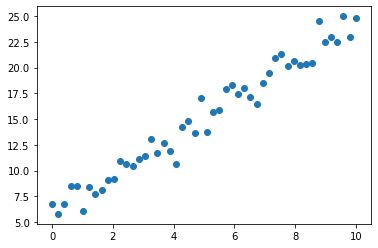

In [9]:
# Exercise 5
np.random.seed(0)
X = np.linspace(0,10,50)[:,np.newaxis]
y = 2 * X.squeeze() + 5 + np.random.normal(size=50)

plt.scatter(X,y)

In [30]:
# Exercise 6

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)
model2= LinearRegression(normalize=True)
model2.fit(X_train,y_train)

print ("mean squared error:", metrics.mean_squared_error(model.predict(X_test), y_test))



mean squared error: 0.5743588276371987


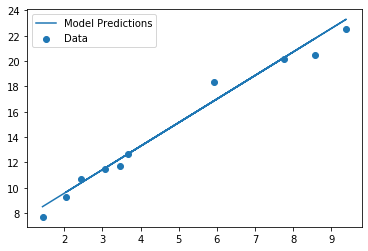

In [31]:
y_pred=model.predict(X_test)
plt.figure()
plt.scatter(X_test,y_test,label="Data")
plt.plot(X_test,y_pred,label="Model Predictions")
plt.legend()

In [28]:
X.shape,X_test.shape

((50, 1), (40, 1))

Degree:  1  Error:  1.620633493457999
Degree:  2  Error:  1.0123306737234103
Degree:  3  Error:  0.7591276824272327
Degree:  4  Error:  0.642382707351224
Degree:  5  Error:  0.5273746949430155
Degree:  6  Error:  0.5801184778231192
Degree:  7  Error:  0.6130792400693383
Degree:  8  Error:  0.6027694825600365
Degree:  9  Error:  0.6014718333552235
Degree:  10  Error:  0.5987221100519929
Degree:  11  Error:  0.5983662256258333
Degree:  12  Error:  0.591547910951364
Degree:  13  Error:  0.5781669906616733
Degree:  14  Error:  0.5799109137822664
Degree:  15  Error:  0.5779820809930112


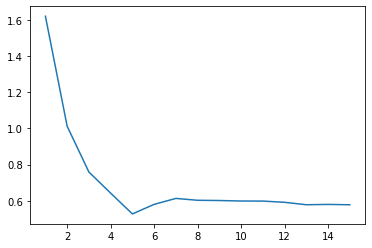

In [69]:
# Exercise 7
degrees=range(1,9)
e=np.zeros(8)

for i in range(8):
    model = PolynomialRegression(degree=degrees[i])
    model.fit(X_train, y_train)
    e[i]=model.err(X_val,y_val)
    print("Degree: ", degrees[i]," Error: ",e[i])
    
plt.plot(degrees,e)

In [97]:
# HW Exercise 
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((400, 2), (100, 2), (400,), (100,))